In [1]:
import cv2
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration

Populating the interactive namespace from numpy and matplotlib


In [2]:
yamlfile=os.environ['REPO_DIR']+'/shape_params.yaml'
params=configuration(yamlfile).getParams()
print(params)

{'name': 'local', 'paths': {'s3stem': 's3://mousebraindata-open/MD657', 'patches': 'permuted', 'DiffusionMap': '/Users/kuiqian/Github/shapeology_code/notebooks/diffusionMap', 'scripts_dir': '/Users/kuiqian/Github//shapeology_code/scripts', 'data_dir': '/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/'}, 'preprocessing': {'polarity': -1, 'min_std': 10, 'offset': -20, 'min_area': 10}, 'normalization': {'size_thresholds': [15, 51, 201]}}


/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [3]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1


In [4]:
def get_scores(X_train, X_valid, y_train, param):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_valid)
    num_round = 100
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)
    score = bst.predict(dval, output_margin=True, ntree_limit=bst.best_ntree_limit)
    score = np.around(score, 3)
    
    return score

In [5]:
def get_predictions(y_pred_valid):
    y_pred_sort = np.argsort(y_pred_valid, axis=1)[:,::-1]
    predictions_valid = y_pred_sort[:, 0]
    
    return predictions_valid

In [6]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

In [3]:
stack = 'MD589'
patch_dir=os.environ['ROOT_DIR']+'CSHL_regions/'+stack+'/'
structure = '5N'
objects=os.listdir(patch_dir+structure)
sofar = 0
name = ""
for item in objects:
    size = os.path.getsize(patch_dir+structure+'/'+item)
    if size>sofar:
        sofar = size
        name = item
name = "158.tif"
patches=[]
patches.append(patch_dir+structure+'_surround_200um_noclass/'+name)
patches.append(patch_dir+structure+'/'+name)
patches

['/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/5N_surround_200um_noclass/158.tif',
 '/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/5N/158.tif']

In [102]:
features = []
labels = []
t0= time()
for state in range(2):
    patch = patches[state]
    extractor=patch_extractor(params)
    tile=cv2.imread(patch,0)
    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    if _std < min_std:
        print('image',patches[i],'std=',_std, 'too blank, skipping')
    else:
        Stats=extractor.segment_cells(tile)
        cells= extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        #cells = cells[cells['padded_size']==201]
        #cells = cells[['DMVec','area']]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for i in range(len(cells)):
            cells[i][0] = cells[i][0][:10]
        features.extend(np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1))
        labels.extend([state]*len(cells))
print(time()-t0)

5.0581769943237305


In [103]:
#features = np.array(features[:,-1]).reshape(-1,1)
#features = np.concatenate((features[:,:10],features[:,-1].reshape(-1,1)),axis=1)
features = np.array(features)
labels = np.array(labels)
features.shape, labels.shape, sum(labels==1), sum(labels==0)

((2370, 20), (2370,), 834, 1536)

In [56]:
90/2.17, 288/5.64, 1097/31.07

(41.474654377880185, 51.06382978723405, 35.30737045381397)

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
X_train.shape, X_valid.shape

((1659, 20), (711, 20))

In [341]:
y_pred_valid = get_scores(X_train, X_valid, y_train, param)
pred = y_pred_valid>0
#pred = get_predictions(y_pred_valid)
acc = sum(pred ==y_valid)/len(y_valid)
acc

0.8518518518518519

In [283]:
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [336]:
pred = clf.predict(X_valid)
acc = sum(pred == y_valid)/len(y_valid)
acc

0.863013698630137

In [33]:
x = sort(X_train[:,10])
size=x.shape[0]
y=arange(0,size)/size
threshold = [x[np.argmin(np.absolute(y-0.1*(1+j)))] for j in range(10)]

In [113]:
def CDF(x, color, state, threshold):
    x=sort(x)
    size=x.shape[0]
    y=arange(0,size)/size
    num = len(threshold)
    ten_x = [x[np.argmin(np.absolute(x-threshold[j]))] for j in range(num)]
    ten_y = [y[np.argmin(np.absolute(x-threshold[j]))] for j in range(num)]
    if color:
        plot(x,y,color, label=state)
        plot(ten_x,ten_y,'ro')
    else:
        plot(x,y, label=state)
        plot(ten_x,ten_y,'o')
    legend()

In [97]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    columns.append(name)
columns.extend(origin)

In [137]:
import pickle
fp = os.environ['ROOT_DIR']+'CSHL_data_processed/MD589/ThresholdsV3.pkl'
thresholds = pickle.load(open(fp,'rb'))

In [128]:
k=12
threshold_full = thresholds['5N'][k]
threshold = [threshold_full[10*j] for j in range(10)]

In [129]:
threshold_full

[0.5619065349954468,
 0.598116425473326,
 0.6249740228761612,
 0.647775689553809,
 0.6660091950634435,
 0.6836452140639592,
 0.7011820935519999,
 0.7147548977860931,
 0.7308395441941885,
 0.747093096423497,
 0.7633472817190465,
 0.7794033355024302,
 0.7950924472414448,
 0.8124049881107752,
 0.830004270015801,
 0.850273753600219,
 0.8698569284190917,
 0.8890084370184516,
 0.9120654224840475,
 0.9339532564849532,
 0.9570243433573081,
 0.9781512600517025,
 1.001159753543284,
 1.0259019243799403,
 1.0528747287747988,
 1.0778128106323934,
 1.10303452879143,
 1.1296698215241152,
 1.1584783593881371,
 1.1878610674155594,
 1.2169385990467902,
 1.2490016423638148,
 1.2799097065608056,
 1.3122725331711924,
 1.3434275458120186,
 1.3738812999741148,
 1.4034356265870116,
 1.4340091067236378,
 1.464322688266974,
 1.4945097856739817,
 1.5249518064205563,
 1.5561995177618182,
 1.5834843779734622,
 1.6124099431966397,
 1.6398639216558957,
 1.6658501208898129,
 1.6921454018176407,
 1.7174762203089526,
 

In [105]:
k=14
threshold = thresholds[structure]
threshold = threshold[10*k:10*(k+1)]
threshold

[15, 51, 51, 51, 51, 51, 51, 51, 201, 201]

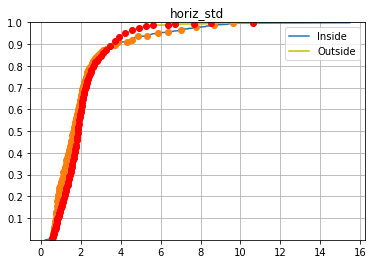

In [130]:
CDF(X_train[y_train==1][:,k],False, 'Inside',threshold_full)
CDF(X_train[y_train==0][:,k],'y', 'Outside',threshold_full)
title(columns[k])
#xlabel('Area')
minor_ticks = np.arange(1, 11, 1)/10
yticks(minor_ticks)
ylim(0,1)
#xlim(0,2500)
grid(True)
#savefig('CDF.jpg')
#grid(which='minor',alpha=0.2)
#CDF(X_valid[y_valid==1][:,0])
#CDF(X_valid[y_valid==0][:,0])

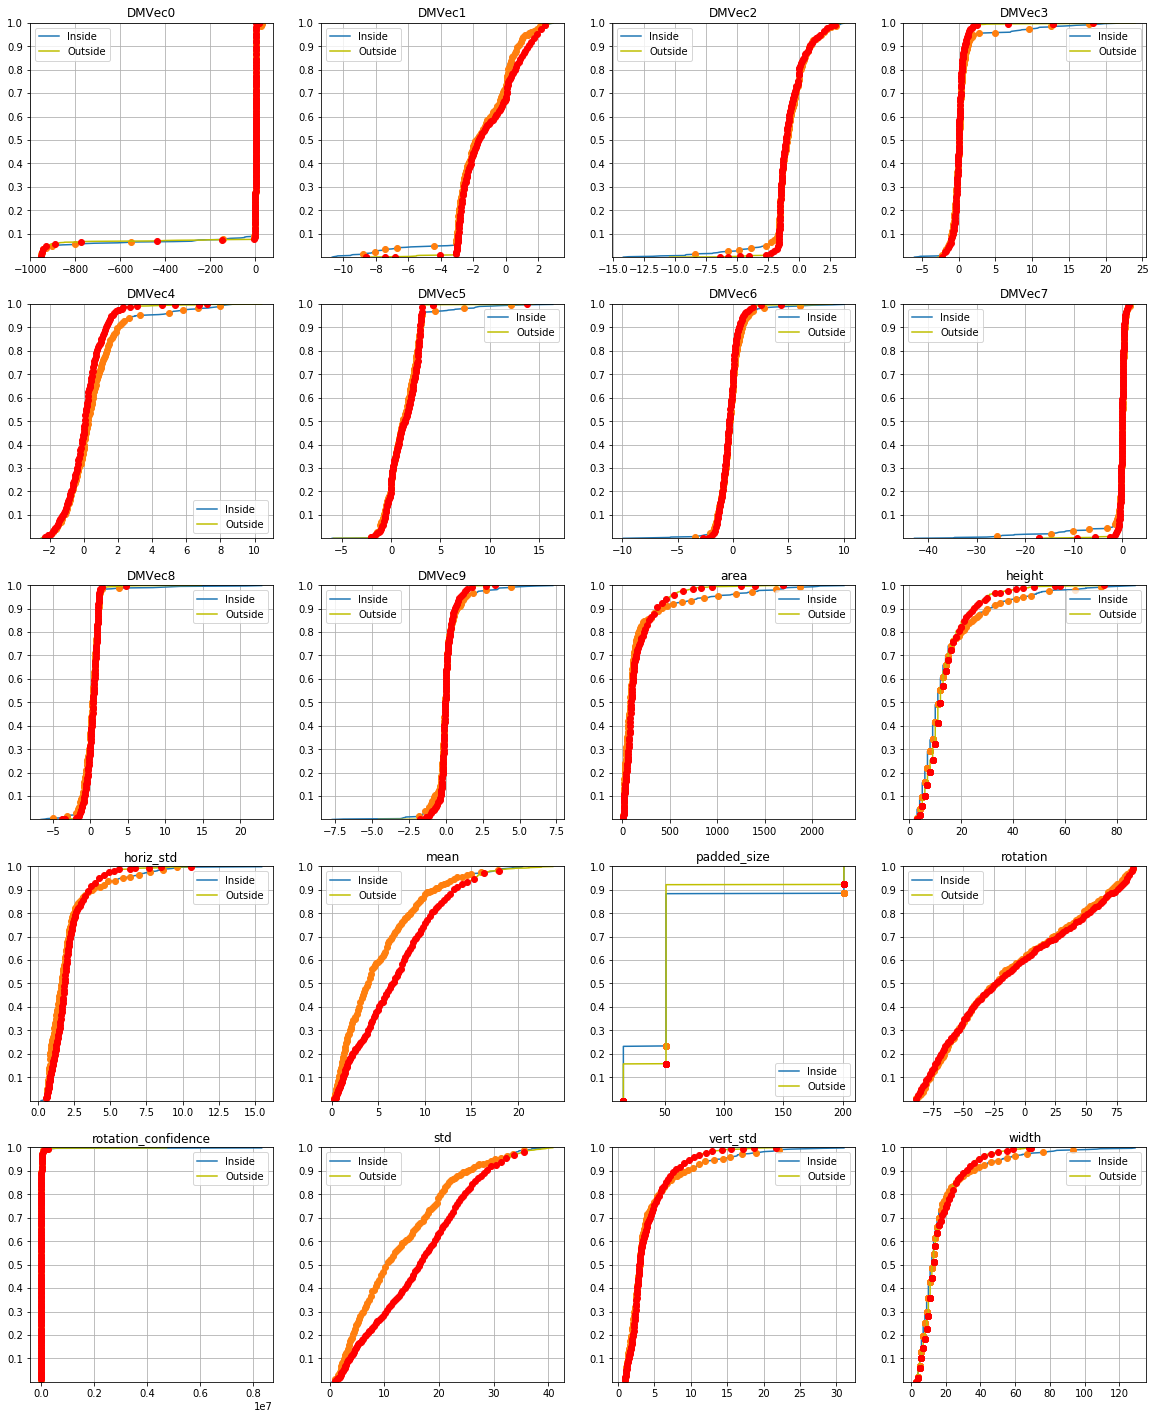

In [138]:
figure(figsize=(20,25))
for k in range(20):
    subplot(5,4,k+1)
    threshold = thresholds[structure]
    threshold = threshold[k]#[10*k:10*(k+1)]
    CDF(X_train[y_train==1][:,k],False, 'Inside',threshold)
    CDF(X_train[y_train==0][:,k],'y', 'Outside',threshold)
    title(columns[k])
    #xlabel('Area')
    minor_ticks = np.arange(1, 11, 1)/10
    yticks(minor_ticks)
    ylim(0,1)
    #xlim(0,2500)
    grid(True)

In [321]:
for structure in all_structures:
    objects=os.listdir(patch_dir+structure)
    sofar = 0
    name = ""
    for item in objects:
        size = os.path.getsize(patch_dir+structure+'/'+item)
        if size>sofar:
            sofar = size
            name = item
    patches=[]
    patches.append(patch_dir+structure+'_surround_200um_noclass/'+name)
    patches.append(patch_dir+structure+'/'+name)
    features = []
    labels = []
    #t0= time()
    for state in range(2):
        patch = patches[state]
        extractor=patch_extractor(patch,params)
        tile=cv2.imread(patch,0)
        if params['preprocessing']['polarity']==-1:
            tile = 255-tile
        min_std=params['preprocessing']['min_std']
        _std = np.std(tile.flatten())

        if _std < min_std:
            print('image',patches[i],'std=',_std, 'too blank, skipping')
        else:
            Stats=extractor.segment_cells(tile)
            cells= extractor.extract_blobs(Stats,tile)
            cells = pd.DataFrame(cells)
            cells = cells[cells['padded_patch'].notnull()]
            #cells = cells[cells['padded_size']==201]
            #cells = cells[['DMVec','area']]
            cells = cells.drop(['padded_patch','left','top'],1)
            cells = np.asarray(cells)
            for i in range(len(cells)):
                cells[i][0] = cells[i][0][:10]
            features.extend(np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1))
            labels.extend([state]*len(cells))
    #print(time()-t0)
    features = np.array(features)
    labels = np.array(labels)
    print(sum(labels==1), sum(labels==0))
    X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.30, random_state=6)
    y_pred_valid = get_scores(X_train, X_valid, y_train, param)
    pred = y_pred_valid>0
    #pred = get_predictions(y_pred_valid)
    acc = sum(pred ==y_valid)/len(y_valid)
    print(structure, acc)

1112 1798
5N 0.6563573883161512
110 861
6N 0.9143835616438356
1162 1601
7N 0.594692400482509
1162 1601
7n 0.594692400482509
172 1153
Amb 0.8618090452261307
959 1939
LC 0.6471264367816092
1033 1711
LRt 0.6080097087378641
1703 1450
Pn 0.6490486257928119
455 1506
Tz 0.7792869269949066
1747 2290
VLL 0.6212871287128713
554 1433
RMC 0.7035175879396985
223 1356
SNC 0.8523206751054853
2049 2519
SNR 0.5951859956236324
472 1359
3N 0.7509090909090909
42 618
4N 0.9292929292929293
2530 2154
Sp5I 0.5889046941678521
4736 3564
Sp5O 0.58714859437751
3844 2385
Sp5C 0.6243980738362761
408 1611
PBG 0.7838283828382838
233 1987
10N 0.8858858858858859
2159 2191
VCA 0.6183908045977011
1632 2159
VCP 0.6010544815465729
1954 2580
DC 0.6282145481263777
675 794
AP 0.5918367346938775
842 2286
12N 0.7124600638977636
1504 2254
RtTg 0.5416666666666666
8373 4964
SC 0.623688155922039
5893 3485
IC 0.6275764036958067


In [3]:
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_regions_features/MD589/'
structures=[dir for dir in glob(cell_dir+'*')]
patches=[dir for dir in glob(structures[0]+'/*')]

In [4]:
patches

['/data/BstemAtlasDataBackup/ucsd_brain/CSHL_regions_features/MD589/5N/MD589_5N_positive.pkl']

In [5]:
import pickle

In [8]:
feature = pickle.load(open(patches[0],'rb'))

In [9]:
look = np.array(feature)

In [10]:
look.shape

(44, 201)